In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
import time
import datetime as dt
import random
import psutil
from PIL import Image
import matplotlib.pyplot as plt
from random import shuffle
import glob
import pickle
import torchvision
from torch.optim import lr_scheduler
import torch.nn.functional as F
import math
import time

import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

def no_of_params(model):
    sum_ = 0.
    for key, value in model.state_dict().items():
        sum_ += torch.prod(torch.tensor(value.shape))
        #print(value, "----------", torch.prod(torch.tensor(value.shape)))
    return int(sum_)

In [13]:
class Dataset(torch.utils.data.Dataset):
    def __init__(
        self,
        list_IDs,
    ):
        self.list_IDs  = list_IDs
        self.cache     = {}
        self.input_dir = "D:/Harsh Workspace/Software/GU/instrument_position_detection_using_ML/data/set_4/images/"
        self.label_dir = "D:/Harsh Workspace/Software/GU/instrument_position_detection_using_ML/data/set_4/labels/"
        
    def __len__(self):
        return len(self.list_IDs)
    
    def __getitem__(self, index):
        ID = self.list_IDs[index]
        if ID in self.cache:
            X = self.cache[ID]['X']
            Y = self.cache[ID]['Y']
        else:
            X = torchvision.io.read_image(
                self.input_dir + str(ID) + ".png "
            ).to(torch.float32)
            X = X[1].unsqueeze(0)/256.
            
            with open(self.label_dir + str(ID), 'rb') as fb:
                Y  = pickle.load(fb)
                
            #Y = [ (i + 3.)/6. for i in Y[0] ] + [i/3.14 for i in Y[1]]
            #Y = [ i/3. for i in Y[0] ] + [i/3.14 for i in Y[1]]
            
            Y = Y[1][0]/3.1415926
            Y = Y - 0.5
            
            Y = torch.tensor( Y, dtype=torch.float32 ).unsqueeze(0)
            
            if psutil.virtual_memory().percent < 50:
                data = {
                    'X' : X,
                    'Y' : Y
                }
                self.cache[ID] = data
        return X,Y
    
all_ids = [str(i) for i in  list(np.arange(0,10000,1))]
#train_ids = all_ids[:8000]
#val_ids   = all_ids[8000:]#1000]

train_ids = all_ids[:800]
val_ids   = all_ids[800:1000]#1000]

params = {
    'batch_size'  : 8,
    'shuffle'     : True,
    #'num_workers' : 2
}
training_set         = Dataset(train_ids)
training_generator   = torch.utils.data.DataLoader(
                            training_set,
                            **params,
                            pin_memory=True
                        )
validation_set       = Dataset(val_ids)
validation_generator = torch.utils.data.DataLoader(
                            validation_set,
                            **params,
                            pin_memory=True
                        )

In [14]:
def train_one_epoch(
    model,
    optimizer,
    loss_fn
):
    running_loss = 0.
    #loss_fn = nn.MSELoss()
    #loss_fn = nn.L1Loss()
    
    model.train(True)
    
    for i,batch in enumerate(training_generator):
        X = batch[0]
        Y = batch[1]
        output = model(batch[0])
        loss = loss_fn(Y, output)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        del X,Y,output
    
    return running_loss/(i+1)

def validate_one_epoch(
    model,
    optimizer,
    loss_fn
):
    running_loss = 0.
    #loss_fn = nn.MSELoss()
    #loss_fn = nn.L1Loss()
    model.train(False)
    model.eval()
    
    for i,batch in enumerate(validation_generator):
        X = batch[0]
        Y = batch[1]
        output = model(batch[0])
        loss = loss_fn(Y, output)
        #optimizer.step()
        
        running_loss += loss.item()
        del X,Y,output
    
    return running_loss/(i+1)

In [15]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1  = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, stride=1, padding=1)
        self.bn1    = nn.BatchNorm2d(8)
        self.conv2  = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=1, padding=1)
        self.bn2    = nn.BatchNorm2d(16)
        self.pool   = nn.MaxPool2d(2,2)
        self.conv4  = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=1)
        self.bn4    = nn.BatchNorm2d(32)
        self.conv5  = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=1)
        self.bn5    = nn.BatchNorm2d(64)
        self.fc1    = nn.Linear(64*10*10, 1)

    def forward(self, input):
        output = torch.tanh(self.bn1(self.conv1(input)))      
        output = torch.tanh(self.bn2(self.conv2(output)))     
        output = self.pool(output)                        
        output = torch.tanh(self.bn4(self.conv4(output)))     
        output = torch.tanh(self.bn5(self.conv5(output))) 
        #print(output.shape)
        output = output.view(-1, 64*10*10)
        output = self.fc1(output)
        output = torch.tanh(output)

        return output
model = Network()
no_of_params(model)

74405

In [8]:
lr = 1e-7
wd = 1e-3
model = Network()

epochs = 300
optimizer = torch.optim.Adam(
        model.parameters(),
        lr           = lr,
        weight_decay = wd,
    )

scheduler = lr_scheduler.CyclicLR(
    optimizer,
    base_lr=3e-8,
    max_lr=3e-7,
    cycle_momentum=False,
    gamma=1,
    step_size_up=10,
    step_size_down =10,
    mode='triangular2',
)

train_losses = []
val_losses   = []
lrs          = []

loss_fn = nn.MSELoss()
#loss_fn = nn.L1Loss()

for epoch in range(epochs):
    train_loss = train_one_epoch(model,optimizer,loss_fn)
    val_loss   = validate_one_epoch(model,optimizer,loss_fn)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    #optimizer.step()
    lrs.append(scheduler.optimizer.param_groups[0]['lr'])
    scheduler.step()
    print("EPOCH: ",epoch + 1, " Train loss: ", round(train_loss,4), " Val loss: ",round(val_loss,4), " LR: ",round(scheduler.optimizer.param_groups[0]['lr'],10))

# txt = "learning rate: " + str(lr) +  " weight decay: " + str(wd)
# plt.title(txt)
# plt.plot(train_losses)
# plt.plot(val_losses)
# plt.show()

# for batch in validation_generator:
#     break
# output = model(batch[0])
# output
# plt.title(txt)
# plt.plot(output.detach().numpy()*3.1415926)
# plt.plot(batch[1].detach().numpy()*3.1415926)
# plt.show()

EPOCH:  1  Train loss:  0.2789  Val loss:  0.2765  LR:  5.7e-08
EPOCH:  2  Train loss:  0.2461  Val loss:  0.2315  LR:  8.4e-08
EPOCH:  3  Train loss:  0.1957  Val loss:  0.1728  LR:  1.11e-07
EPOCH:  4  Train loss:  0.1357  Val loss:  0.1106  LR:  1.38e-07
EPOCH:  5  Train loss:  0.0803  Val loss:  0.0594  LR:  1.65e-07
EPOCH:  6  Train loss:  0.0409  Val loss:  0.0276  LR:  1.92e-07
EPOCH:  7  Train loss:  0.0242  Val loss:  0.0213  LR:  2.19e-07
EPOCH:  8  Train loss:  0.0312  Val loss:  0.0383  LR:  2.46e-07
EPOCH:  9  Train loss:  0.0605  Val loss:  0.0737  LR:  2.73e-07
EPOCH:  10  Train loss:  0.1005  Val loss:  0.1188  LR:  3e-07
EPOCH:  11  Train loss:  0.1429  Val loss:  0.1627  LR:  2.73e-07
EPOCH:  12  Train loss:  0.1781  Val loss:  0.192  LR:  2.46e-07
EPOCH:  13  Train loss:  0.1996  Val loss:  0.2102  LR:  2.19e-07
EPOCH:  14  Train loss:  0.2101  Val loss:  0.2191  LR:  1.92e-07
EPOCH:  15  Train loss:  0.2128  Val loss:  0.2197  LR:  1.65e-07
EPOCH:  16  Train loss:  

EPOCH:  126  Train loss:  0.0506  Val loss:  0.0541  LR:  3.25e-08
EPOCH:  127  Train loss:  0.0504  Val loss:  0.0542  LR:  3.3e-08
EPOCH:  128  Train loss:  0.0504  Val loss:  0.0543  LR:  3.34e-08
EPOCH:  129  Train loss:  0.0506  Val loss:  0.0543  LR:  3.38e-08
EPOCH:  130  Train loss:  0.0506  Val loss:  0.054  LR:  3.42e-08
EPOCH:  131  Train loss:  0.0507  Val loss:  0.0541  LR:  3.38e-08
EPOCH:  132  Train loss:  0.0506  Val loss:  0.0543  LR:  3.34e-08
EPOCH:  133  Train loss:  0.0508  Val loss:  0.0543  LR:  3.3e-08
EPOCH:  134  Train loss:  0.0507  Val loss:  0.0541  LR:  3.25e-08
EPOCH:  135  Train loss:  0.0509  Val loss:  0.054  LR:  3.21e-08
EPOCH:  136  Train loss:  0.0508  Val loss:  0.0542  LR:  3.17e-08
EPOCH:  137  Train loss:  0.0507  Val loss:  0.0542  LR:  3.13e-08
EPOCH:  138  Train loss:  0.0509  Val loss:  0.0542  LR:  3.08e-08
EPOCH:  139  Train loss:  0.0507  Val loss:  0.0542  LR:  3.04e-08
EPOCH:  140  Train loss:  0.0509  Val loss:  0.0544  LR:  3e-08
EP

EPOCH:  250  Train loss:  0.0398  Val loss:  0.0427  LR:  3.01e-08
EPOCH:  251  Train loss:  0.0399  Val loss:  0.0427  LR:  3.01e-08
EPOCH:  252  Train loss:  0.0398  Val loss:  0.0427  LR:  3.01e-08
EPOCH:  253  Train loss:  0.0398  Val loss:  0.0427  LR:  3e-08
EPOCH:  254  Train loss:  0.0398  Val loss:  0.0426  LR:  3e-08
EPOCH:  255  Train loss:  0.0397  Val loss:  0.0426  LR:  3e-08
EPOCH:  256  Train loss:  0.0398  Val loss:  0.0426  LR:  3e-08
EPOCH:  257  Train loss:  0.0398  Val loss:  0.0427  LR:  3e-08
EPOCH:  258  Train loss:  0.0398  Val loss:  0.0426  LR:  3e-08
EPOCH:  259  Train loss:  0.0398  Val loss:  0.0426  LR:  3e-08
EPOCH:  260  Train loss:  0.0397  Val loss:  0.0425  LR:  3e-08
EPOCH:  261  Train loss:  0.0397  Val loss:  0.0426  LR:  3e-08
EPOCH:  262  Train loss:  0.0397  Val loss:  0.0426  LR:  3e-08
EPOCH:  263  Train loss:  0.0397  Val loss:  0.0426  LR:  3e-08
EPOCH:  264  Train loss:  0.0397  Val loss:  0.0426  LR:  3e-08
EPOCH:  265  Train loss:  0.039

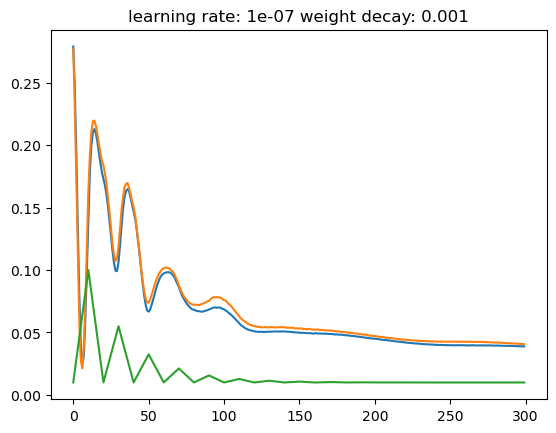

# DATA 2 Times

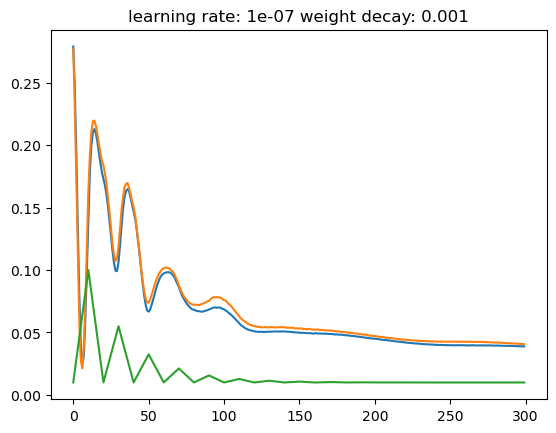

In [10]:
txt = "learning rate: " + str(lr) +  " weight decay: " + str(wd)
plt.title(txt)
plt.plot(train_losses)
plt.plot(val_losses)
plt.plot( [lr/3e-6 for lr in lrs ])
plt.show()

1.0553269799668836


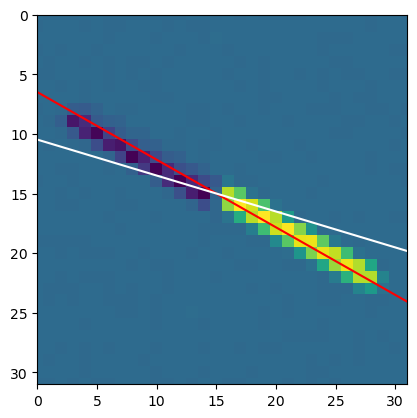

1.9640977574231073


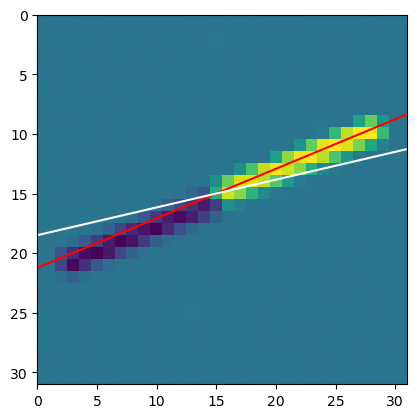

0.7732709527235844


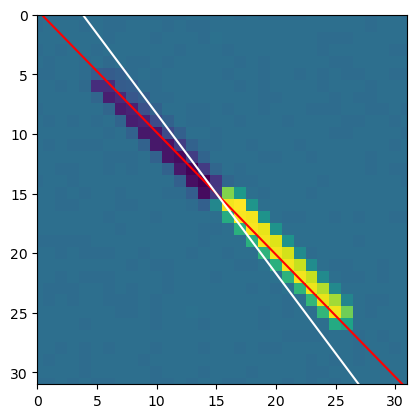

2.036336585706218


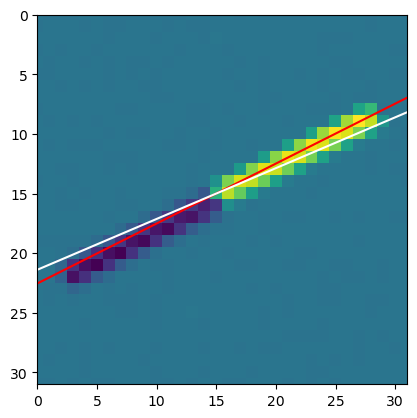

1.0425236213896572


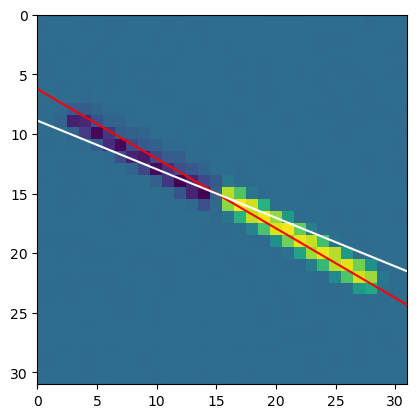

1.6613049321162372


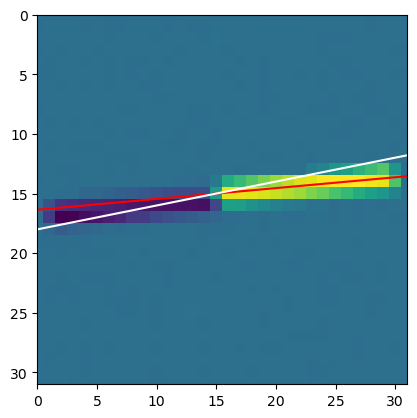

0.03141285476712673


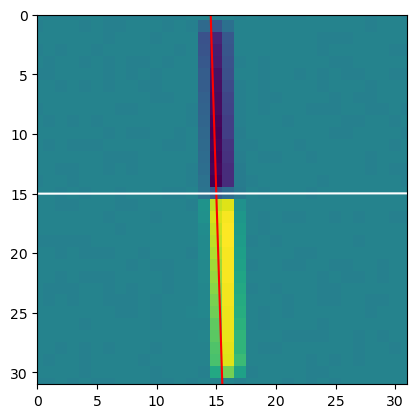

1.7031753686514217


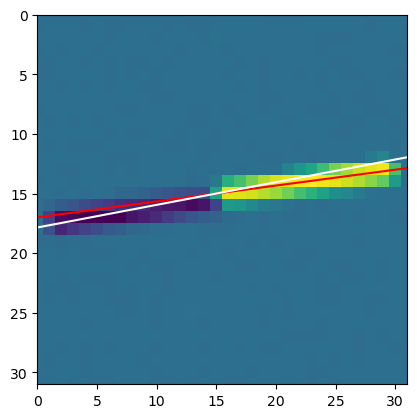

2.3872511188579373


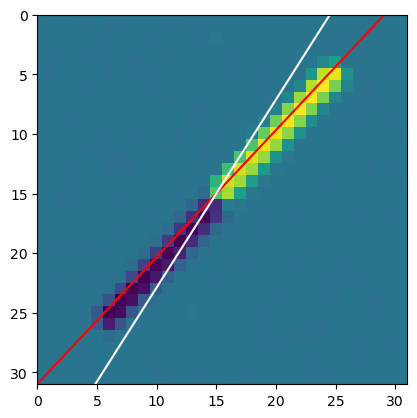

1.9247181892858514


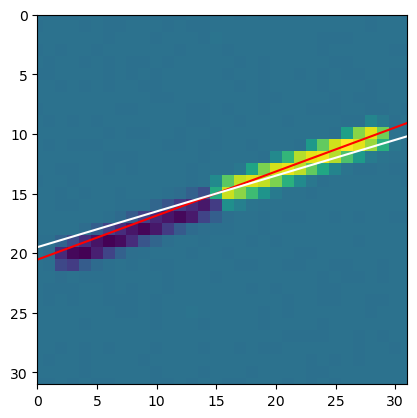

0.34105972031187015


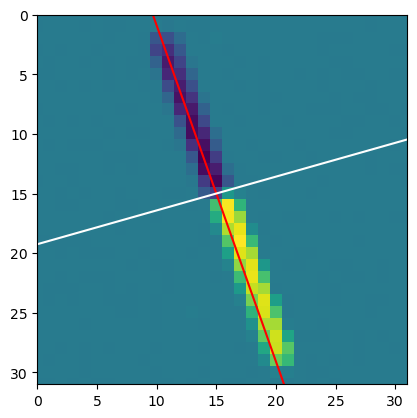

2.0085469966821914


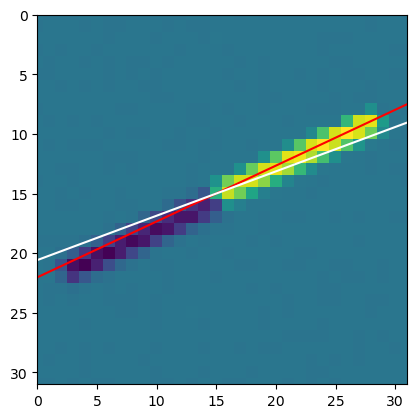

0.7643171966721869


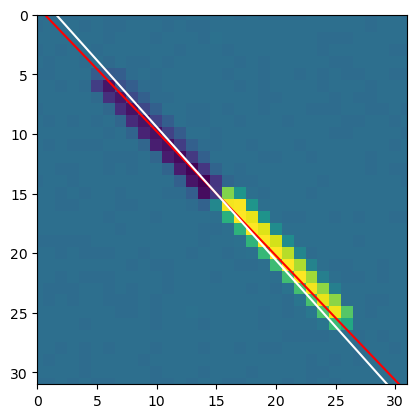

3.1031433431977478


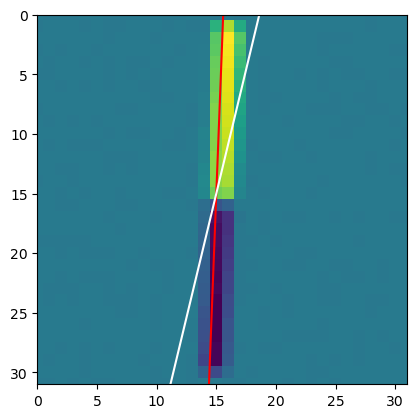

2.5878322800197067


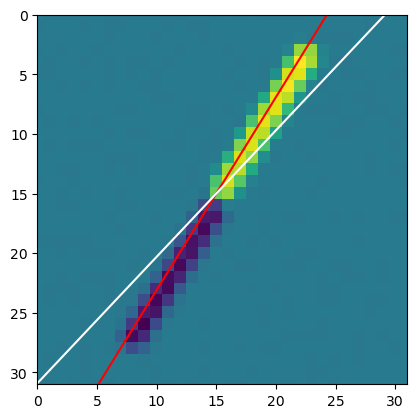

1.8768943214665907


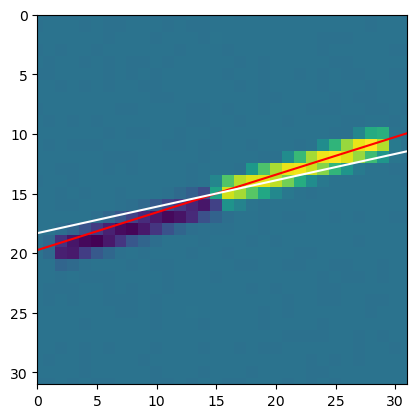

0.3234698764215406


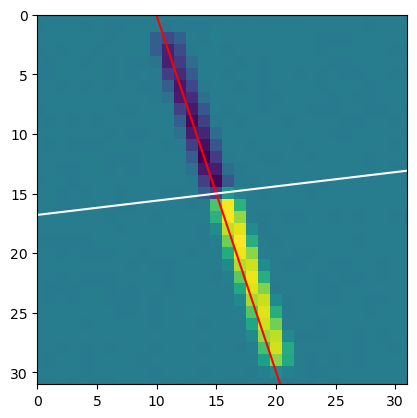

1.6780937169303924


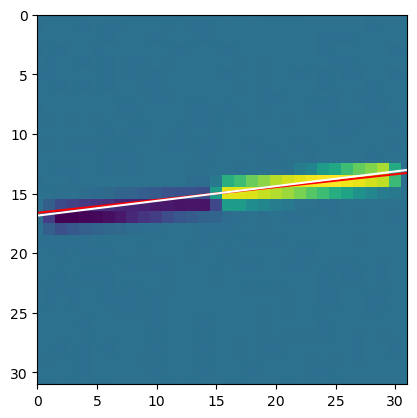

0.5001283029422734


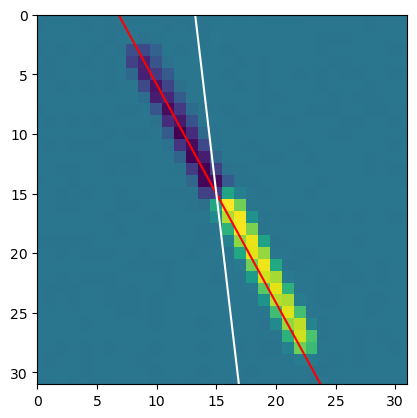

2.2822426088771346


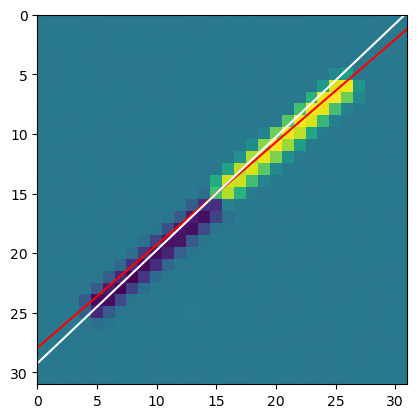

1.6531659247729837


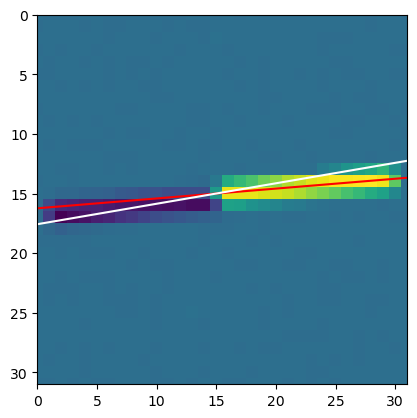

2.089236318663971


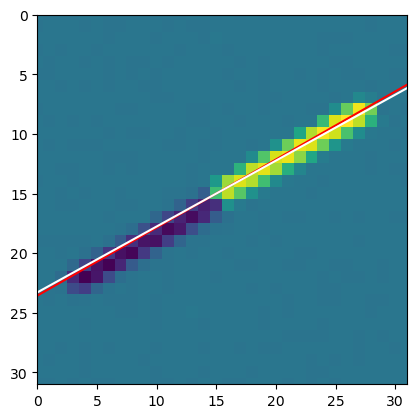

1.6531659247729837


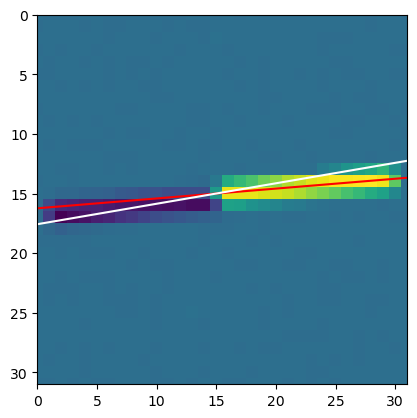

2.428566767624946


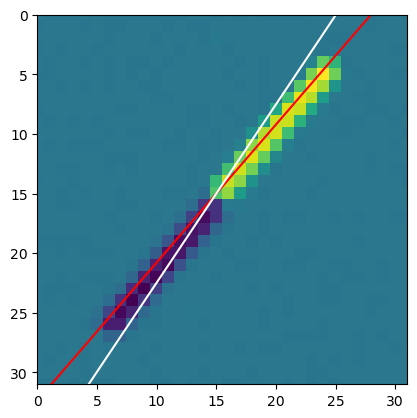

1.4548385281820022


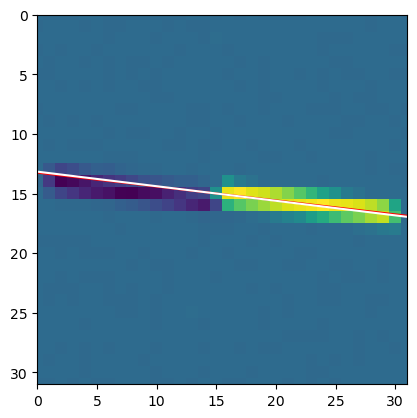

0.8952774631906669


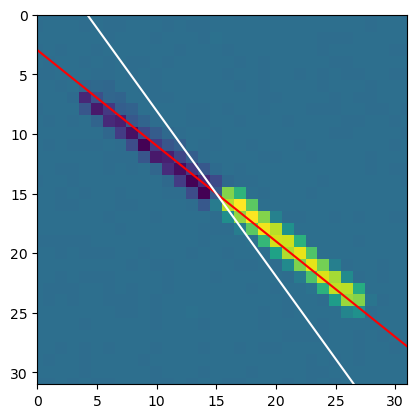

1.368692607955879


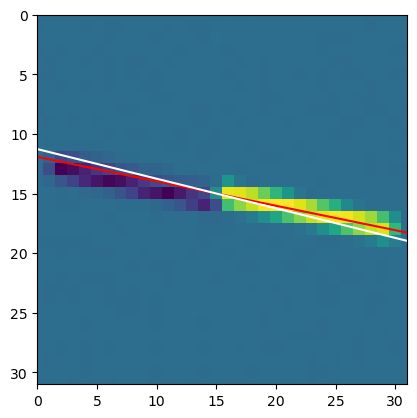

0.6210018483837172


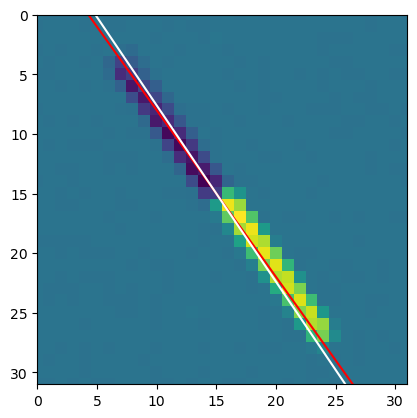

1.2695771451843474


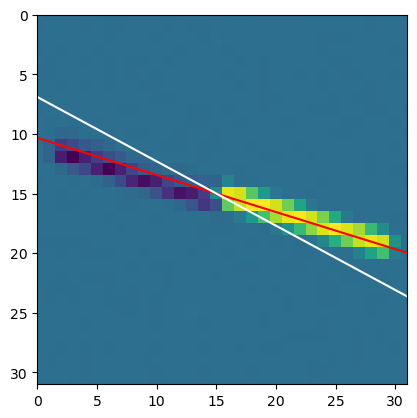

3.0335172200058924


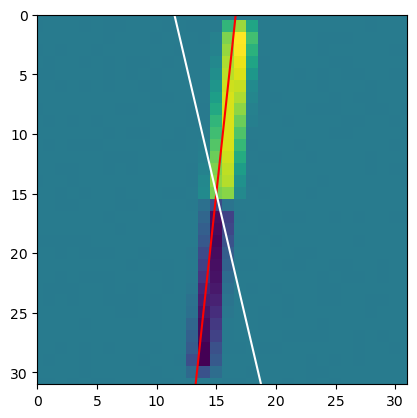

In [11]:
test_IDs = [ random.randint(0,999) for i in range(100) ]

real = []
outputs = []
for ID in test_IDs[:30]:
    input_dir = "D:/Harsh Workspace/Software/GU/instrument_position_detection_using_ML/data/set_4/images/"
    label_dir = "D:/Harsh Workspace/Software/GU/instrument_position_detection_using_ML/data/set_4/labels/"
    
    X = torchvision.io.read_image(
                input_dir + str(ID) + ".png "
            ).to(torch.float32)
    plt.imshow(X[1])
    X = X/256.
    
    with open(label_dir + str(ID), 'rb') as fb:
        Y  = pickle.load(fb)
        Y = Y[1][0]#/3.1415926
        
    #Y = Y + 0.5
        
    output = (float(model(X[1].unsqueeze(0).unsqueeze(0))) + 0.5 )*3.1415926
    print(Y)
    
    real.append(Y)
    outputs.append(output)
    
    #plt.plot( [16 - 50*math.tan(Y),16 ,16 + 50*math.tan(Y)],[16 - 50, 16,16 + 50], c='r')
    plt.plot( [15 - 50*math.tan(Y),15 ,15 + 50*math.tan(Y)],[15 - 50, 15,15 + 50], c='r')
    plt.plot( [15 - 50*math.tan(output),15 ,15 + 50*math.tan(output)],[15 - 50, 15,15 + 50], c='w')
    
    plt.xlim(0,31)
    plt.ylim(31,0)
    
    #plt.axvline( x = (Y + 1)*16, c='w' )
    #plt.axvline( x = (output + 1.)*16, c='r')
    plt.show()
    
        

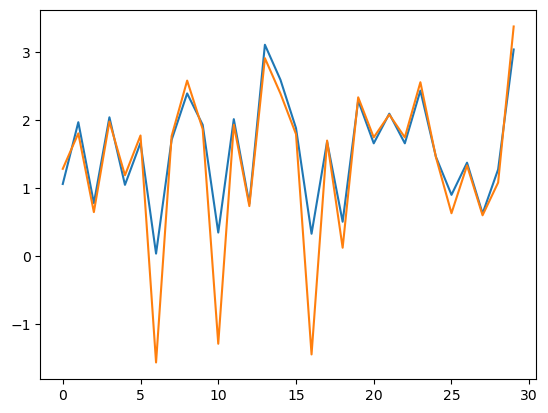

In [12]:
plt.plot(real)
plt.plot(outputs)